In [1]:
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import json
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.rcParams.update({'font.size': 18})


onlyfiles = [f for f in listdir("output") if isfile(join("output", f))]

data_map = {}

rps_set = set()
cons_set = set()
exes_set = set()

run_files = [o for o in onlyfiles if o.endswith(".txt") and o.startswith("run")]

for output in run_files:
    with open("output/{}".format(output), 'r') as f:
        json_str = ""
        latency_strs = []
        start_latency = False
        start_json = False
        for line in f:
            if re.search(r"^#\[Mean", line):
                start_latency = False
            if start_latency and not start_json:
                latency_strs.append(line)
            if start_json:
                json_str = "{}{}".format(json_str,line)
            if line == "JSON Output:\n":
                start_json = True
            if re.search(r"^\s+Value\s+Percentile\s+TotalCount.*", line):
                start_latency = True
        all_percentiles = [re.split(r"\s+", s.strip(" \n"))[:2] for s in latency_strs]
        run = json.loads(json_str)
        run["all_percentiles"] = [y for y in [[x for x in s if x != ''] for s in all_percentiles if len(s) > 0] if y != []]
        run_parts = output.split(".")[0].split("-")
        exe = run_parts[1]
        rps = run_parts[2]
        cons = run_parts[3]
        rps_set.add(rps)
        cons_set.add(cons)
        exes_set.add(exe)
        if exe not in data_map:
            data_map[exe] = {}
        if cons not in data_map[exe]:
            data_map[exe][cons] = {}
        if rps not in data_map[exe][cons]:
            data_map[exe][cons][rps] = {}
        data_map[exe][cons][rps] = run

In [2]:
def extract_from_results(cons, f):
    all_lists = []
    for exe in data_map:
        l = []
        for rps in data_map[exe][str(cons)]:
            l.append([rps,f(data_map[exe][str(cons)][rps])])
        l.sort(key=lambda x: int(x[0]))
        all_lists.append(l)
    return all_lists

def latency_percentile(perct):
    def get_percentile(y):
        lat_dist = y['latency_distribution']
        percentile = next((v for v in lat_dist if v['percentile'] == perct), None)
        print(percentile)
        if percentile:
            return percentile['latency_in_microseconds']
        else:
            return None
    return get_percentile

def extract_percentiles_only(cons, rps):
    all_percentiles = []
    exes = []
    for exe in data_map:
        l = data_map[exe][str(cons)][str(rps)]["all_percentiles"]
        new_series = pd.Series([float(v[0]) for v in l], index=[str(v[1]) for v in l], name=exe)
        new_series = new_series[~new_series.index.duplicated(keep='first')]
        all_percentiles.append(new_series)
    return pd.concat(all_percentiles, axis=1)

styles = ['-',':','-.']

In [3]:
cons = "1000"

rps_results = []

for exe in exes_set:
    r = []
    for (rps,val) in data_map[exe][cons].items():
        r.append([float(rps), val['requests_per_sec']])
    r = sorted(r, key=lambda x: x[0])
    rps_results.append(pd.Series([x[1]/1000 for x in r], index=[x[0]/1000 for x in r], dtype=np.float64, name=exe))
    
rps_df = pd.concat(rps_results, axis=1).rename(columns={'httpserv_effects':'MC',
                                                        'httpserv_go':'go',
                                                        'httpserv_lwt':'lwt'})
rps_df = rps_df[['MC', 'lwt', 'go']]

rps_df

,MC,lwt,go
2.5,2.49701,2.49881,2.49890
5.0,4.98571,4.98562,4.98894
10.0,9.96935,9.96966,9.95791
15.0,14.95156,14.94191,14.94791
20.0,19.94569,19.90613,19.95759
25.0,24.91173,24.92304,24.93958
30.0,29.90787,29.88920,29.90999
35.0,32.52013,32.45339,31.39736
40.0,31.29071,32.53720,32.33372
45.0,32.22249,31.43942,32.20383


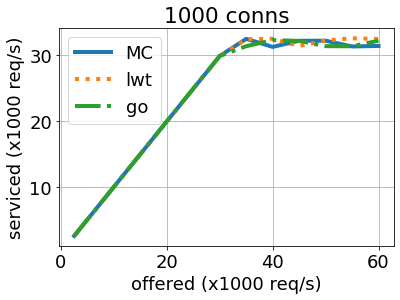

In [4]:
p = rps_df.plot(xlabel="offered (x1000 req/s)", ylabel="serviced (x1000 req/s)",
            grid=True, title="1000 conns",style=styles,lw=4)

In [5]:
p.get_figure().savefig("throughput.pdf", bbox_inches='tight')

In [6]:
percentiles = extract_percentiles_only(1000, 20000).rename(columns={'httpserv_go':'go',
                                                                    'httpserv_effects':'MC',
                                                                    'httpserv_lwt':'lwt'},
                                                           index=lambda i:str(round(float(i)*100,8)))
percentiles

,MC,lwt,go
0.0,0.047,0.047,0.047
10.0,0.494,0.521,0.479
20.0,0.718,0.769,0.687
30.0,0.905,0.975,0.858
40.0,1.071,1.167,1.012
...,...,...,...
99.9996,17.887,22.767,21.167
99.9997,17.887,22.767,21.167
99.9998,17.919,22.783,21.231
99.9999,17.983,22.831,21.263


/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


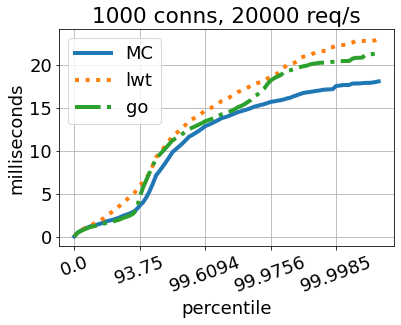

In [7]:
p = percentiles.plot(xlabel="percentile", 
                 ylabel="milliseconds", 
                 title=("{} conns, {} req/s".format(1000, 20000)), 
                 grid=True,
                 style=styles,lw=4)

for tick in p.get_xticklabels():
    tick.set_rotation(20)

In [8]:
p.get_figure().savefig("latency.pdf", bbox_inches='tight')